### Variance in E and M scales with number of steps?
See lab book p. 29

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# parameters
n_slope = 5000
n_burnin = 10000
n_analyze = 10000000 #10,000,000. Unreasonably high
n_steps = n_slope + n_burnin + n_analyze # ising.py takes this as an arg instead of n_slope
N = 100 # 100x100 lattice
b_top = 0.5 # B annealing from .5 to break symmetry at low temperatures

# T = 2.3 (far from critical temp the effect here is less significant)
t_min = 2.3
t_step = 1
t_max = 2.4

multiprocess = False # irrelevant for getting only one temperature value. Also my code doesn't work with multiprocess yet

# run simulation (takes about 2.5 minutes per million samples)
# NOTE: this puts data in temporary directories (here, 'snapshots', 'data', and 'series'). Should be moved IMMEDIATELY
# (shell commands to move the data are in the next two cells)

# !python ising.py n_steps:$n_steps n_burnin:$n_burnin n_analyze:$n_analyze N:$N b_top:$b_top t_min:$t_min t_max:$t_max \
#                  t_step:$t_step multiprocess:$multiprocess

In [45]:
Experiment_name = "10M"
!mkdir datatests/$Experiment_name 
!mv data datatests/$Experiment_name
!mv snapshots datatests/$Experiment_name
!mv series datatests/$Experiment_name
!mkdir data
!mkdir snapshots
!mkdir series

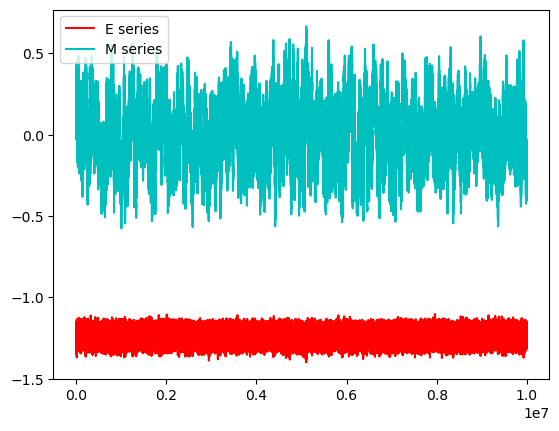

In [3]:
# load data and plot, to check shape

experiment_name = "10M"
# get just the data after annealing
long_E = np.load(f"datatests/{experiment_name}/series/E_series.npy")[0][n_burnin+n_slope:]
long_M = np.load(f"datatests/{experiment_name}/series/M_series.npy")[0][n_burnin+n_slope:]
plt.plot(long_E, label='E series', c='r')
plt.plot(long_M, label='M series', c='c')
plt.legend(loc='upper left')
plt.show()

0.00016205403076968993


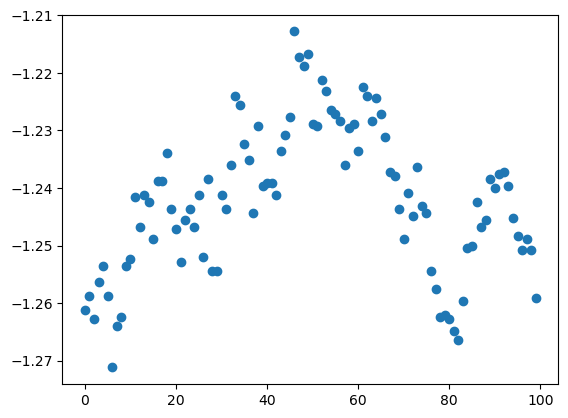

In [16]:
plt.scatter(range(100), long_E[4000000:4000100])
print(np.var(long_E[4000000:4000000 + 100]))

In [51]:
# check that np.var does what I want it to do
print(np.average(np.square(long_M)) - (np.average(long_M)**2))
print(np.var(long_M))

0.03580723796511467
0.03580723796511462


The next few cells calculate variance in M (linearly related to susceptibility) over differently-sized blocks of the total M series (we modified the simulation to output a full time series in addition to average/std).

For each block size, we then calculate an average variance in M and standard error bars on that average variance.
These values are then plotted vs. the number of steps per group (first graph) (log scale) and the number of groups (second graph). These are the same data, just organized differently.

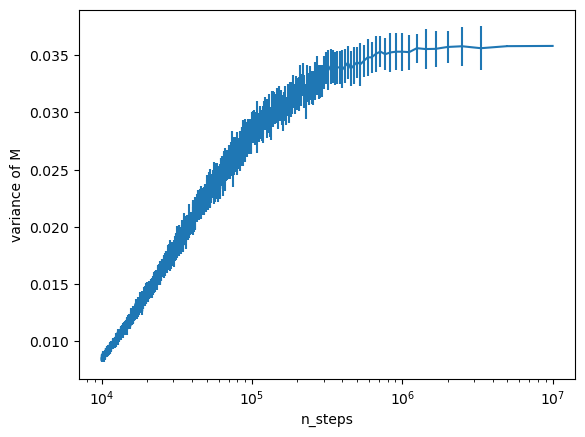

In [4]:
n_split = range(1, 1000)
chi_split = np.ndarray((1000))
e_chi_split = np.ndarray((1000))
for i in n_split:
    # split M series data into i equal pieces
    split_m = np.array_split(long_M, i)
    # calculate chi for each piece
    chi_split_vals = [np.var(x) for x in split_m]
    # get average value of chi over all pieces
    chi_split[i] = np.average(chi_split_vals)
    # get standard error for chi over all pieces (assuming gaussian dist)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
    
plt.errorbar(n_analyze/np.array(range(1, 1000)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("n_steps")
plt.ylabel("variance of M")
plt.xscale('log')
plt.show()

n_steps = 10k
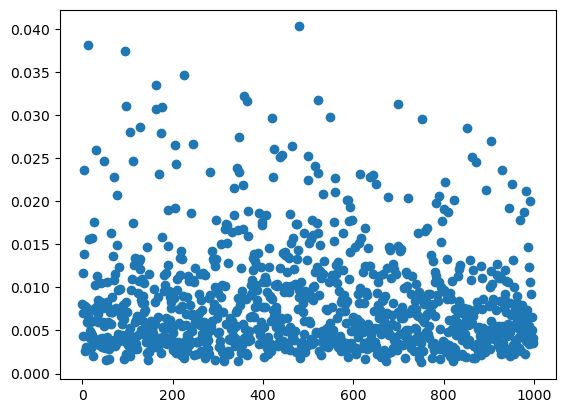

0.028769995357758708


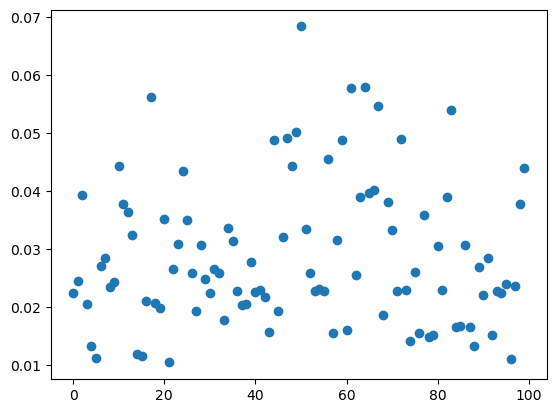

In [20]:
i = 100
# split M series data into i equal pieces
split_m = np.array_split(long_M, i)
# calculate chi for each piece
chi_split_vals = [np.var(x) for x in split_m]
plt.scatter(range(len(chi_split_vals)), chi_split_vals)
print(np.average(chi_split_vals))

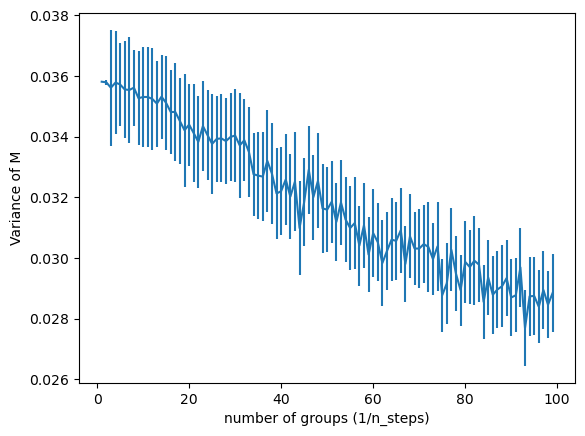

In [20]:
n_split = range(1, 100)
chi_split = np.ndarray((100))
e_chi_split = np.ndarray((100))
for i in n_split:
    split_m = np.array_split(long_M, i)
    # chi_split_vals = [np.average(np.square(x)) - (np.average(np.abs(x))**2) for x in split_m] # equivalent to next line
    chi_split_vals = [np.var(x) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(np.array(range(1, 100)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("number of groups (1/n_steps)")
plt.ylabel("Variance of M")
plt.show()

The next two cells produce analagous graphs but for E instead of M. Please ignore the unchanged local variable names

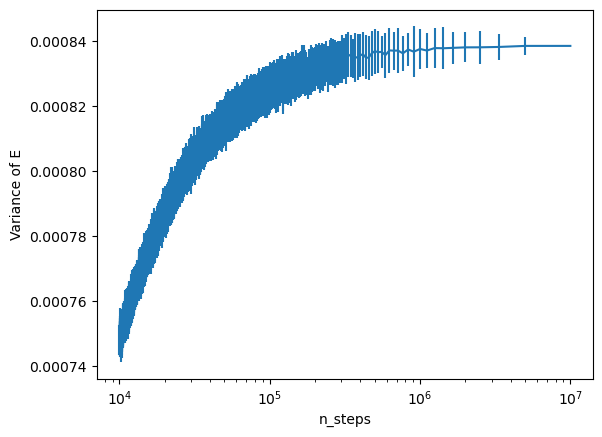

In [28]:
n_split = range(1, 1000)
chi_split = np.ndarray((1000))
e_chi_split = np.ndarray((1000))
for i in n_split:
    split_m = np.array_split(long_E, i) # now uses long_E instead of long_M
    chi_split_vals = [np.var(x) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(n_analyze/np.array(range(1, 1000)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("n_steps")
plt.ylabel("Variance of E")
plt.xscale('log')
plt.show()

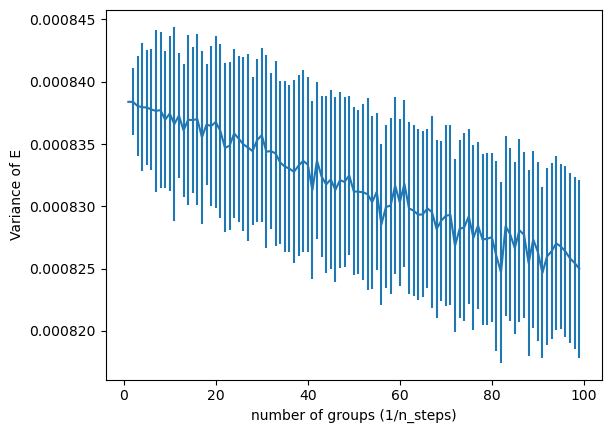

In [21]:
n_split = range(1, 100)
chi_split = np.ndarray((100))
e_chi_split = np.ndarray((100))
for i in n_split:
    split_m = np.array_split(long_E, i)
    chi_split_vals = [np.var(np.abs(x)) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(np.array(range(1, 100)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("number of groups (1/n_steps)")
plt.ylabel("Variance of E")
plt.show()

This next bit is what leads me to think the issue here is local correlations. When the total data (10M steps) is *shuffled*, the scaling disappears.

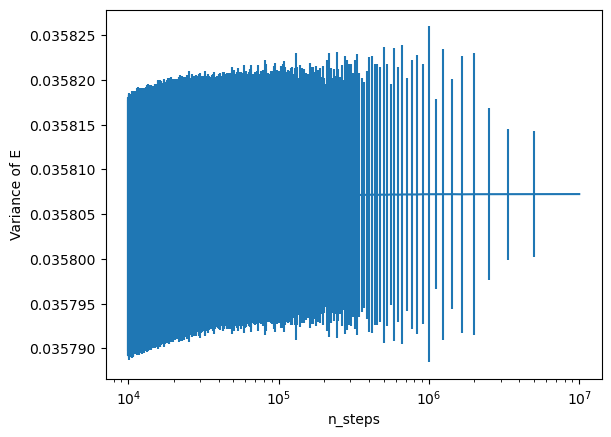

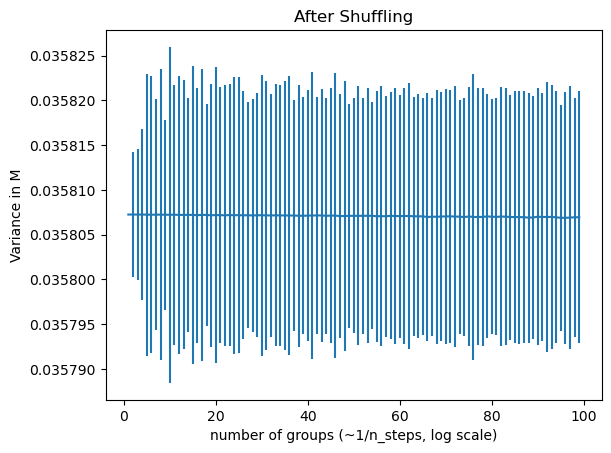

In [30]:
# If the issue is local correlations, shuffling the M values should drop this effect
shuffled = np.copy(long_M) # copy array so I don't mess with the original
np.random.shuffle(shuffled) # shuffle M series

# and then just run the same exact code
n_split = range(1, 1000)
chi_split = np.ndarray((1000))
e_chi_split = np.ndarray((1000))
for i in n_split:
    split_m = np.array_split(shuffled, i) # now uses long_E instead of long_M
    chi_split_vals = [np.var(x) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(n_analyze/np.array(range(1, 1000)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("n_steps")
plt.ylabel("Variance of M")
plt.xscale('log')
plt.show()

n_split = range(1, 100)
chi_split = np.ndarray((100))
e_chi_split = np.ndarray((100))
for i in n_split:
    split_m = np.array_split(shuffled, i)
    chi_split_vals = [np.var(x) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(np.array(range(1, 100)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("number of groups (~1/n_steps)")
plt.ylabel("Variance in M")
plt.title("After Shuffling")
plt.show()

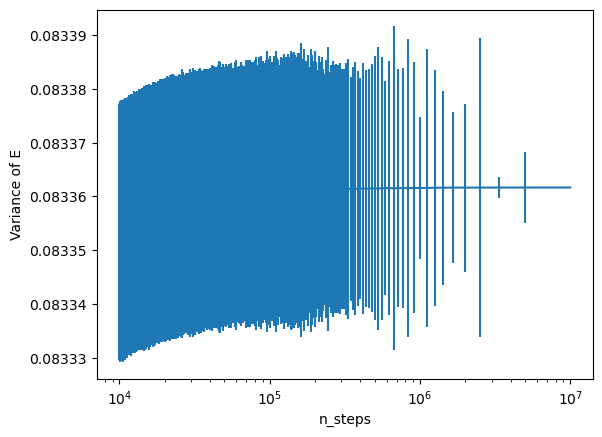

In [23]:
rando = np.random.rand(100000)
n_split = range(1, 1000)
chi_split = np.ndarray((1000))
e_chi_split = np.ndarray((1000))
for i in n_split:
    split_m = np.array_split(rando, i) # now uses long_E instead of long_M
    chi_split_vals = [np.var(x) for x in split_m]
    chi_split[i] = np.average(chi_split_vals)
    e_chi_split[i] = np.std(chi_split_vals)/np.sqrt(i)
plt.errorbar(100000/np.array(range(1, 1000)), chi_split[1:], yerr=e_chi_split[1:])
plt.xlabel("n_steps")
plt.ylabel("Variance of E")
plt.xscale('log')
plt.show()